# Sentiment Analysis of Valkyr's Rework (Warframe)

In [35]:
import pickle
import pandas as pd
import numpy as np

In [36]:
with open('data/forum_posts.pkl', 'rb') as f:
    df = pickle.load(f)
df.head()

,author,likes,date,comment
0,[DE]Sam,102,May 9,"VALKYR\nTenno, A berserker’s fury fills the ai..."
1,oswarlan,352,May 10,"Honestly, losing the invulnerability on Hyster..."
2,StageNameFrank,49,May 10,"finally, valkyr's slide attack isn't the only ..."
3,18K-,10,May 10,Love it!
4,dice,18,May 10,Valkyr's Warcry is now recastable. Hooray!


## Preprocessing

The only columns that can have missing values are `author`, `date` and `comment`.

In [37]:
print(np.sum(df.loc[:, 'author'] == ''), np.sum(df.loc[:, 'date'] == ''), np.sum(df.loc[:, 'comment'] == ''))

0 0 2


In [38]:
df.loc[df.loc[:,'comment'] == '', :]

,author,likes,date,comment
93,0phiuchus,5,May 10,
1679,Heavy_Calibre,8,May 12,


Only two comments are missing, and they do not have many likes, so I will remove them:

In [39]:
df = df.loc[df.loc[:,'comment'] != '', :]
df.shape

(1898, 4)

Finally, let's reset the indexes:

In [40]:
# Reset index count, but don't store the old ones as a new column
df.reset_index(drop=True, inplace=True) 
df.tail()

,author,likes,date,comment
1893,Thyralion,0,May 12,"thats not what it ways on the post, it says ""C..."
1894,(PSN)ClockworkSiren,5,May 12,The problem is how would you increase your new...
1895,Tueneap,1,May 12,It is exactly what it says in the post. But ye...
1896,UndPanzer,10,May 12,"I love how this whole discussion is useless, e..."
1897,hambub,9,May 12,I'm starting to get really confused by some of...


### Text Cleaning
Although it is advantageous to use text as it is for sentiment analysis, later steps require cleaned text data.

In [41]:
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
# import nltk
# nltk.download('punkt')
# nltk.download('stopwords')

def clean_text(text: str):
    # Lowercase
    text = text.lower()

    # # Remove punctuation
    # text = re.sub(pattern='[^a-zA-Z\d\s]', repl='', string=text)

    # Tokenization
    words = word_tokenize(text, language='english')

    # Remove Stop-Words
    stopwords_set = set(stopwords.words('english'))
    return [w for w in words if w not in stopwords_set and len(w) > 4]

df['clean_comment'] = df['comment'].apply(clean_text)
df.head()

,author,likes,date,comment,clean_comment
0,[DE]Sam,102,May 9,"VALKYR\nTenno, A berserker’s fury fills the ai...","[valkyr, tenno, berserker, fills, corpus, grin..."
1,oswarlan,352,May 10,"Honestly, losing the invulnerability on Hyster...","[honestly, losing, invulnerability, hysteria, ..."
2,StageNameFrank,49,May 10,"finally, valkyr's slide attack isn't the only ...","[finally, valkyr, slide, attack, viable]"
3,18K-,10,May 10,Love it!,[]
4,dice,18,May 10,Valkyr's Warcry is now recastable. Hooray!,"[valkyr, warcry, recastable, hooray]"


## Sentiment Classification

To begin with, let's classify in basic polarities — positive, neutral and negative —, which can be done with the `nltk` library and its `VADER` lexicon.

In [42]:
# Download required lexicon 
import nltk
# nltk.download('vader_lexicon') # <--- uncomment this line to download

In [91]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Initialize VADER sentimen analyzer
sid = SentimentIntensityAnalyzer()

# Analyze each comment
results = {
    'index': [], 'negative_score': [], 'neutral_score': [], 
    'positive_score': [], 'compound': [], 'label': []
}

for index, post in df.iterrows():
    comment = post[-2]
    scores = sid.polarity_scores(comment)

    # Store scores
    results['index'].append(index)
    results['negative_score'].append(scores['neg'])
    results['neutral_score'].append(scores['neu'])
    results['positive_score'].append(scores['pos'])
    results['compound'].append(scores['compound'])
    results['label'].append(
        'positive' if scores['compound'] > 0.5
        else 'negative' if scores['compound'] < -0.5
        else 'neutral'
    )

In [92]:
data = pd.DataFrame.from_dict(results)
data.head(10)

,index,negative_score,neutral_score,positive_score,compound,label
0,0,0.293,0.604,0.103,-0.9988,negative
1,1,0.260,0.491,0.249,-0.1027,neutral
2,2,0.220,0.780,0.000,-0.4767,neutral
3,3,0.000,0.182,0.818,0.6696,positive
4,4,0.000,0.582,0.418,0.5562,positive
5,5,0.000,0.753,0.247,0.3182,neutral
6,6,0.127,0.873,0.000,-0.4404,neutral
7,7,0.000,0.417,0.583,0.6808,positive
8,8,0.000,0.741,0.259,0.4939,neutral
9,9,0.278,0.722,0.000,-0.4019,neutral


## Data Exploration

In [93]:
data_no_introduction = data.copy()
data_no_introduction = data_no_introduction.drop(0, axis=0)

In [94]:
negative_comments = data_no_introduction.loc[data_no_introduction['label'] == 'negative', 'index']
positive_comments = data_no_introduction.loc[data_no_introduction['label'] == 'positive', 'index']
neutral_comments = data_no_introduction.loc[data_no_introduction['label'] == 'neutral', 'index']

In [96]:
indexes = negative_comments
comments = df.loc[indexes, ('clean_comment')]

all_words = []
for comment in comments:
    all_words.extend(comment)

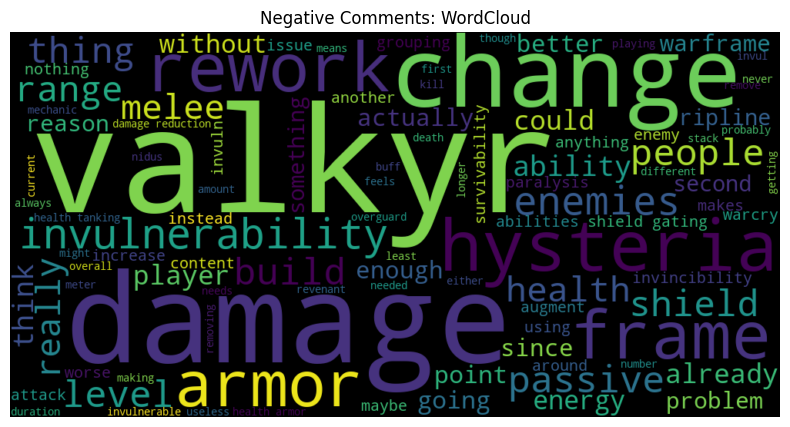

In [97]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

cloud = WordCloud(
    width=1000, height=500, background_color='black', contour_width=10,
    max_words=100, stopwords=('still', 'would')
).\
    generate(' '.join(all_words))
plt.figure(figsize=(10,5))
plt.imshow(cloud, interpolation='bilinear')
plt.axis('off')
plt.title('Negative Comments: WordCloud')
plt.show()

In [48]:
"isn't" in stopwords.words('english')

True